# Satelligence_data_ingestion_&_h3_error_mitigation_QA

# [H3 data QA exploration:](#H3dataQAexploration:)

1. Upsample and ingest as density
2. Change library to h3pandas
3. Custon Zonal statistics using the h3 data as vector geoms and data in unsampled format
4. Custom zonal statistics using h3 data as vector geo and data in raw format

# [Replicate the analysis using Satelligence data:](#ReplicatetheanalysisusingSatelligencedata:)

    1. Deforestation
    2. Carbon
    3. Biodiversity
        - 3-a. species richness
        - 3-b. WDPA

# [Pixel - h3 index area ratio:](#pixelarearatio:)

1. Rubber rpoduction
2. Deforestation
3. Carbon
4. Biodiversity

In [1]:
# imort libraries
import geopandas as gpd
import h3pandas
import pandas as pd
from h3ronpy import raster
from rasterstats import zonal_stats
import rasterio as rio
import h3
from shapely.geometry import Point


import rioxarray as rxr
from shapely.geometry import mapping, shape

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define functions
def buffer_stats(raster_path, vector_path, buffer=50000, stat_='sum', all_touched = True):
    """
    inputs:
    -------------
    raster_path: raster path for retriving the statisticts in EPSG:4326
    vector_path: path to point file in EPSG:4326
    buffer: distance in metres for coputing the buffer
    stats: stadistics to compute
    
    output
    -------
    array with statistics"""
    
    #open vector file
    gdf = gpd.read_file(vector_path)
    #check projection
    #if gdf.crs != True:
    #    print(gdf.crs)
    #    #project
    #    print('Dataset missing projection. Please assign one!')
    if gdf.crs and gdf.crs == 'EPSG:4326':
        #reproject
        gdf_3857 = gdf.to_crs('EPSG:3857')
    ## TODO:add other validations
    

    #get buffer
    gdf_3857_buffer = gdf_3857.buffer(buffer)
    #reproject back to epsg4326
    gdf_4326_buffer = gdf_3857_buffer.to_crs('EPSG:4326')
    #get statistics
    vizz_stats = []
    for geom in gdf_4326_buffer:
        stats = zonal_stats(geom,
                    raster_path,
                    stats=stat_,
                    all_touched = all_touched
            )
        stat_sum = stats[0]['sum']
        vizz_stats.append(stat_sum)
    #add stats in dataframe
    gdf['estimated']=vizz_stats
    return gdf

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])
    
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    dfs['geometry'] =  dfs[hex_col].apply(lambda x: {"type": "Polygon",
                   "coordinates":
                   [h3.h3_to_geo_boundary(
                       h=x, geo_json=True)]
                   })
    dfs["the_geom"] = dfs["geometry"].apply(lambda x: shape(x))
    return dfs

def convert_raster_h3(raster_path, vector_path, column='deforestat', resolution=6):
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

        gdf.plot('value')
        gdf['h3index'] = gdf['h3index'].apply(hex)

    gdf_vector = gpd.read_file(vector_path)
    clean_gdf = gdf_vector[['gfw_fid',column,'geometry']]
    
    _sum_calculated = []
    for i, row in clean_gdf.iterrows():
        filtered_gdf = clean_gdf[i:i+1]
        #convert to h3
        h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
        #h3_gdf = h3_gdf.reset_index().rename(columns={'h3_polyfill':'h3index'})
        h3index_list = [f'0x{h3index}' for h3index in h3_gdf.index]
        #filter gdf by list and get value
        _sum = gdf[gdf['h3index'].isin(h3index_list)]['value'].sum()
        _sum_calculated.append(_sum)
        
    clean_gdf['estimate'] = _sum_calculated
    return clean_gdf

def tiff_to_smooth_h3(raster_path, h3_res, k=2 ):
    """
    Convert tiff to h3 using h3 library and smoothing the result using krigging
    
    Input:
    -------
        Raster_path: tiff to translate to h3. Values below 0 are remove to reduce the size of the output. We are selecting 0 as for these data we should' have negative values
        h3_res: H3 resolution for translating the raster data
        k: degree neighbors return for K ring. Default set to 2
    """
    df = (rxr.open_rasterio(raster_path)
       .sel(band=1)
       .to_pandas()
       .stack()
       .reset_index()
       .rename(columns={'x': 'lng', 'y': 'lat', 0: 'value'}))
    # ignore the 0 values
    df = df[df['value']>0]
    
    #translate to h3
    hex_col = 'hex'+str(h3_res)
    # find hexs containing the points
    df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,h3_res),1)
    # calculate elevation average per hex
    df_ = df.groupby(hex_col)['value'].mean().to_frame('value').reset_index()

    #find center of hex for visualization
    #df_['lat'] = df_[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    #df_['lng'] = df_[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    df_['geometry'] =  df_[hex_col].apply(lambda x: {"type": "Polygon",
                       "coordinates":
                       [h3.h3_to_geo_boundary(
                           h=x, geo_json=True)]
                       })
    df_["the_geom"] = df_["geometry"].apply(lambda x: shape(x))
    
    #3. Apply krigging
    df_s= kring_smoothing(df_, 'hex6', metric_col='value', k=k)
    print('sum sanity check:', df_s['value'].sum() / df_['value'].sum())
    #plot_scatter(df_s, metric_col='prod', marker='o')
    #plt.title('noise complaints: 2-ring average');
    return df_s

def get_h3_gdf_area_ratio(raster_path, resolution, area_raster_km2, stat='max', all_touched=True):
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

        gdf.plot('value')
        gdf['h3index'] = gdf['h3index'].apply(hex)
        gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]

    #obtain area for each hexagon
    hex_area_list = []
    for i, row in gdf.iterrows():
        hex_area = h3.cell_area(row['h3index'])
        hex_area_list.append(hex_area)

    gdf['hex_area_km2'] = hex_area_list

    
    # zonal statistics to get the pixel area
    stats = zonal_stats(gdf,
                        area_raster_km2,
                        stats=stat,
                        all_touched = all_touched
                )
    
    gdf['pix_area_km2'] = [el['max'] for el in stats]
    ratio_list = []
    value_density_list = []
    for i, row in gdf.iterrows():
        ratio = row['hex_area_km2']/row['pix_area_km2']
        ratio_list.append(ratio)
        value_density = row['value']*ratio
        value_density_list.append(value_density)
    gdf['ratio'] = ratio_list
    gdf['val_dens'] = value_density_list
    return gdf

<a id='H3dataQAexploration:'></a>
# H3 data QA exploration:

In [3]:
## datasets to use:
def_sat = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01 (1).tif"
def_sat_area_ha = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif"
mill_point = '../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point.shp'
mill_buffer = '../../datasets/processed/palm_oil_mills/satelligence_mills_4326_buffer.shp'
mill_h3 = '../../datasets/processed/palm_oil_mills/satelligence_buffers_h3.shp'
def_upsampled_area = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif"
def_upsampled_density = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif"


In [4]:
gd_mills = gpd.read_file(mill_h3)
gd_mills.head()

,h3_polyfil,index,area,geometry
0,8665764dfffffff,0,42251779,"POLYGON ((98.36245 2.54701, 98.32945 2.53136, ..."
1,86650db4fffffff,0,42282970,"POLYGON ((98.20927 2.61317, 98.17625 2.59751, ..."
2,86657678fffffff,0,42240582,"POLYGON ((98.16444 2.45310, 98.13145 2.43744, ..."
3,86657606fffffff,0,42088144,"POLYGON ((98.05729 1.91715, 98.02435 1.90152, ..."
4,8665760a7ffffff,0,42127587,"POLYGON ((98.32681 2.11421, 98.29385 2.09858, ..."


## 1 - Raster vector - zonal stats


In [142]:
#zonal stats original raster
zs_raw = buffer_stats(def_sat_area_ha,
             mill_point,
             buffer=50000,
             stat_='sum',
            all_touched = False)

In [143]:
zs_raw

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),349.436371
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),444.854980
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),552.253906
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),621.053894
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),599.887085
5,6.0,1851,PO1000010059,UNKNOWN,SINGKIL SEJAHTERA MAKMUR,SINGKIL SEJAHTERA MAKMUR,Not RSPO Certified,None,2021-07-14,2.462277,...,Aceh Singkil,3-Low Confidence,None,0,e88f2c85-d320-d16b-4521-5199adec82cf,646.2566888648132,494.7889486397643,113174.4700961844,POINT (98.02821 2.46228),646.078979
6,7.0,1412,PO1000007625,UNKNOWN,RUNDING PUTRA PERSADA,RUNDING PUTRA PERSADA,Not RSPO Certified,None,2021-07-14,2.46267,...,Aceh Singkil,1-Fully Verified,None,0,868d7819-4270-a666-e64f-bcc877ed8326,703.6551788812438,551.9323143633895,124408.0447707502,POINT (97.93961 2.46267),703.329224
7,8.0,1653,PO1000008422,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 2,Not RSPO Certified,None,2021-07-14,2.56063,...,Aceh Singkil,1-Fully Verified,None,0,d1304c50-563f-5e26-866c-9c47e8651c87,830.1162625465768,678.5813843497369,149931.9770237909,POINT (97.94867 2.56063),830.123291
8,9.0,1697,PO1000008583,UNKNOWN,BUMI DAYA AGROTAMAS,BUMI DAYA AGROTAMAS,Not RSPO Certified,None,2021-07-14,2.583222,...,Subulussalam,1-Fully Verified,None,0,7e91bbe2-7b15-6da8-38ea-d5093167d101,744.4213553526763,672.9194153953714,135059.8957749358,POINT (97.85417 2.58322),744.409973
9,10.0,1429,PO1000007646,UNKNOWN,GLOBAL SAWIT SEMESTA,SUBULUSSALAM,Not RSPO Certified,None,2021-07-14,2.62,...,Subulussalam,1-Fully Verified,None,0,6551eabb-2cbd-c33b-74b7-7ebabe6f4913,888.7098084608854,737.3136820724134,161829.3224461289,POINT (98.03000 2.62000),888.715210


In [36]:
#calculate zonal statistics using the geometries and the raster in density upsampled so we can see the error that we have from the upsampling
zs_up_area = buffer_stats(def_upsampled_area,
                      mill_point,
                      buffer=50000, 
                      stat_='sum')
zs_up_area

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),436.233215
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),472.174377
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),652.158813
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),785.579895
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),735.794861
5,6.0,1851,PO1000010059,UNKNOWN,SINGKIL SEJAHTERA MAKMUR,SINGKIL SEJAHTERA MAKMUR,Not RSPO Certified,None,2021-07-14,2.462277,...,Aceh Singkil,3-Low Confidence,None,0,e88f2c85-d320-d16b-4521-5199adec82cf,646.2566888648132,494.7889486397643,113174.4700961844,POINT (98.02821 2.46228),749.388000
6,7.0,1412,PO1000007625,UNKNOWN,RUNDING PUTRA PERSADA,RUNDING PUTRA PERSADA,Not RSPO Certified,None,2021-07-14,2.46267,...,Aceh Singkil,1-Fully Verified,None,0,868d7819-4270-a666-e64f-bcc877ed8326,703.6551788812438,551.9323143633895,124408.0447707502,POINT (97.93961 2.46267),785.579895
7,8.0,1653,PO1000008422,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 2,Not RSPO Certified,None,2021-07-14,2.56063,...,Aceh Singkil,1-Fully Verified,None,0,d1304c50-563f-5e26-866c-9c47e8651c87,830.1162625465768,678.5813843497369,149931.9770237909,POINT (97.94867 2.56063),863.140137
8,9.0,1697,PO1000008583,UNKNOWN,BUMI DAYA AGROTAMAS,BUMI DAYA AGROTAMAS,Not RSPO Certified,None,2021-07-14,2.583222,...,Subulussalam,1-Fully Verified,None,0,7e91bbe2-7b15-6da8-38ea-d5093167d101,744.4213553526763,672.9194153953714,135059.8957749358,POINT (97.85417 2.58322),895.604553
9,10.0,1429,PO1000007646,UNKNOWN,GLOBAL SAWIT SEMESTA,SUBULUSSALAM,Not RSPO Certified,None,2021-07-14,2.62,...,Subulussalam,1-Fully Verified,None,0,6551eabb-2cbd-c33b-74b7-7ebabe6f4913,888.7098084608854,737.3136820724134,161829.3224461289,POINT (98.03000 2.62000),884.017578


In [39]:
#calculate zonal statistics using the geometries and the raster in density upsampled so we can see the error that we have from the upsampling
zs_up_density = buffer_stats(def_upsampled_density,
                      mill_point,
                      buffer=50000, 
                      stat_='sum')
zs_up_density['estimated'] = [el*10*10*100 for el in zs_up_density['estimated']]
zs_up_density

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),505.250506
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),546.878017
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),755.338147
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),909.868032
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),852.206349
5,6.0,1851,PO1000010059,UNKNOWN,SINGKIL SEJAHTERA MAKMUR,SINGKIL SEJAHTERA MAKMUR,Not RSPO Certified,None,2021-07-14,2.462277,...,Aceh Singkil,3-Low Confidence,None,0,e88f2c85-d320-d16b-4521-5199adec82cf,646.2566888648132,494.7889486397643,113174.4700961844,POINT (98.02821 2.46228),867.950171
6,7.0,1412,PO1000007625,UNKNOWN,RUNDING PUTRA PERSADA,RUNDING PUTRA PERSADA,Not RSPO Certified,None,2021-07-14,2.46267,...,Aceh Singkil,1-Fully Verified,None,0,868d7819-4270-a666-e64f-bcc877ed8326,703.6551788812438,551.9323143633895,124408.0447707502,POINT (97.93961 2.46267),909.868032
7,8.0,1653,PO1000008422,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 2,Not RSPO Certified,None,2021-07-14,2.56063,...,Aceh Singkil,1-Fully Verified,None,0,d1304c50-563f-5e26-866c-9c47e8651c87,830.1162625465768,678.5813843497369,149931.9770237909,POINT (97.94867 2.56063),999.699235
8,9.0,1697,PO1000008583,UNKNOWN,BUMI DAYA AGROTAMAS,BUMI DAYA AGROTAMAS,Not RSPO Certified,None,2021-07-14,2.583222,...,Subulussalam,1-Fully Verified,None,0,7e91bbe2-7b15-6da8-38ea-d5093167d101,744.4213553526763,672.9194153953714,135059.8957749358,POINT (97.85417 2.58322),1037.299931
9,10.0,1429,PO1000007646,UNKNOWN,GLOBAL SAWIT SEMESTA,SUBULUSSALAM,Not RSPO Certified,None,2021-07-14,2.62,...,Subulussalam,1-Fully Verified,None,0,6551eabb-2cbd-c33b-74b7-7ebabe6f4913,888.7098084608854,737.3136820724134,161829.3224461289,POINT (98.03000 2.62000),1023.879722


## 2. Upsample and ingest as density

1. Convert unsampled data to h3 in res 6
2. Ges statistics

In [38]:
resolution = 6
raster_path = def_upsampled_density

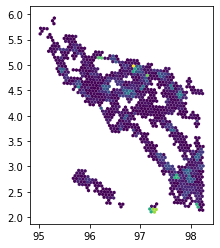

In [39]:
# convert h3 density upsampled data to h3 using h3ronpy
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]


In [24]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf[gdf['h3index'].isin(loc_indexes)]['value'].sum()*3612.9
    location_sum.append(sum_)


## 3. Upsample and ingest as area

1. Convert unsampled data to h3 in res 6
2. Ges statistics

In [145]:
resolution = 6
raster_path = def_upsampled_area

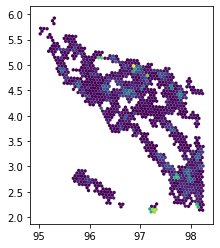

In [146]:
# convert h3 density upsampled data to h3 using h3ronpy
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]

location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf[gdf['h3index'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

## 4 - Using h3 lib - Upsampled deforestation area mask

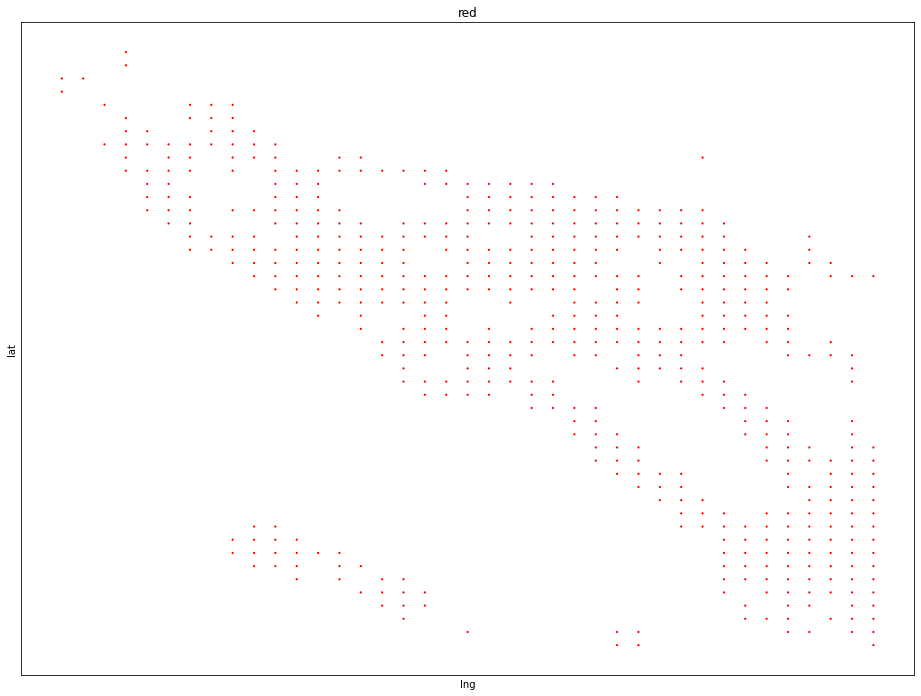

In [25]:
df = (rxr.open_rasterio("../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif")
       .sel(band=1)
       .to_pandas()
       .stack()
       .reset_index()
       .rename(columns={'x': 'lng', 'y': 'lat', 0: 'def_mask'}))
# ignore the 0 values
df = df[df.def_mask>0]

# Visualize the deforestation mas
plot_scatter(df, metric_col='red', marker='.', colormap='gray')



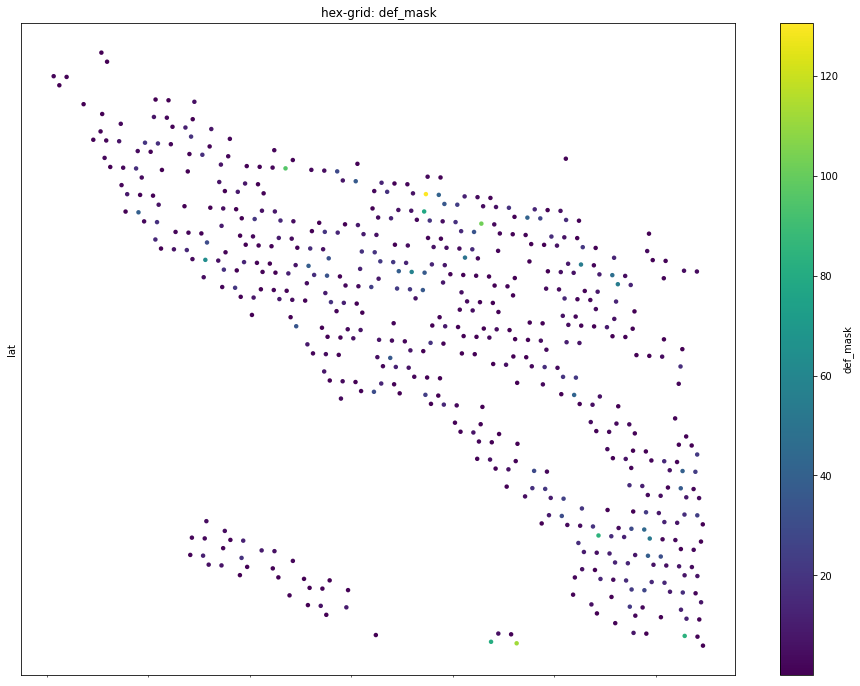

In [37]:
APERTURE_SIZE = 6
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# calculate elevation average per hex
df_ = df.groupby(hex_col)['def_mask'].mean().to_frame('def_mask').reset_index()

#find center of hex for visualization
df_['lat'] = df_[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_['lng'] = df_[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
df_['geometry'] =  df_[hex_col].apply(lambda x: {"type": "Polygon",
                   "coordinates":
                   [h3.h3_to_geo_boundary(
                       h=x, geo_json=True)]
                   })
df_["the_geom"] = df_["geometry"].apply(lambda x: shape(x))
# plot the hexes
plot_scatter(df_, metric_col='def_mask', marker='o')
plt.title('hex-grid: def_mask');

In [21]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_[df_['hex6'].isin(loc_indexes)]['def_mask'].sum()
    location_sum.append(sum_)

In [43]:
df_.set_crs('epsg:4326')

,hex6,def_mask,lat,lng,geometry,the_geom
0,86650906fffffff,3.085363,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732 3.86612, 97.55022 3.90243, ..."
1,866509087ffffff,10.160213,4.142242,97.760754,"{'type': 'Polygon', 'coordinates': [((97.79098...","POLYGON ((97.79099 4.12164, 97.79392 4.15799, ..."
2,86650908fffffff,0.425207,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.72759 4.12649, 97.73052 4.16284, ..."
3,866509097ffffff,5.684348,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...","POLYGON ((97.82708 4.17373, 97.83001 4.21008, ..."
4,8665090a7ffffff,0.152179,4.085304,97.788063,"{'type': 'Polygon', 'coordinates': [((97.81828...","POLYGON ((97.81829 4.06471, 97.82122 4.10105, ..."
...,...,...,...,...,...,...
523,866576757ffffff,0.069625,2.318326,98.026597,"{'type': 'Polygon', 'coordinates': [((98.05663...","POLYGON ((98.05664 2.29790, 98.05958 2.33398, ..."
524,86657676fffffff,0.143228,2.214899,97.954780,"{'type': 'Polygon', 'coordinates': [((97.98482...","POLYGON ((97.98482 2.19449, 97.98775 2.23055, ..."
525,866576787ffffff,2.170794,2.468750,98.197439,"{'type': 'Polygon', 'coordinates': [((98.22747...","POLYGON ((98.22748 2.44831, 98.23044 2.48440, ..."
526,86657678fffffff,16.882961,2.473536,98.134395,"{'type': 'Polygon', 'coordinates': [((98.16444...","POLYGON ((98.16444 2.45310, 98.16739 2.48919, ..."


In [44]:
df_ = df_.set_geometry('the_geom')


In [45]:
df_.to_file("../../datasets/processed/Satelligence_data/h3Pandas_area_def_sat.shp")

## 4 - Using h3 lib - Original deforestation area mask

NOTE: I cannot do this in my local!

In [ ]:
#df = (rxr.open_rasterio(def_sat_area_ha)
#       .sel(band=1)
#       .to_pandas()
#       .stack()
#       .reset_index()
#       .rename(columns={'x': 'lng', 'y': 'lat', 0: 'def_mask'}))
## ignore the 0 values
#df = df[df.def_mask>0]
#
## Visualize the deforestation mas
##plot_scatter(df, metric_col='red', marker='.', colormap='gray')
#
#

## 5 - Zonal statistics of upsampled density data:


In [8]:
zs_ = zonal_stats(mill_h3,
            "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif",
            stats="sum")

In [19]:
def_ha = []
for el in zs_:
    if el['sum'] != None:
        ha_ = float(el['sum'])*3612.9
    else:
        ha_ = 0
    
    def_ha.append(ha_)
    
gd_mills['def_ha'] = def_ha
gd_mills.head()

,h3_polyfil,index,geometry,def_ha
0,8665764dfffffff,0,"POLYGON ((98.36245 2.54701, 98.32945 2.53136, ...",0.000000
1,86650db4fffffff,0,"POLYGON ((98.20927 2.61317, 98.17625 2.59751, ...",1.535592
2,86657678fffffff,0,"POLYGON ((98.16444 2.45310, 98.13145 2.43744, ...",7.064682
3,86657606fffffff,0,"POLYGON ((98.05729 1.91715, 98.02435 1.90152, ...",0.000000
4,8665760a7ffffff,0,"POLYGON ((98.32681 2.11421, 98.29385 2.09858, ...",0.000000


In [31]:
#sum ha en same mills
def_list = []
for index in list(gd_mills['index'].unique()):
    #filter gdf
    def_val = gd_mills[gd_mills['index']==index]['def_ha'].sum()
    def_list.append(def_val)

## 6 - Zonal statistics of upsampled area data:

In [33]:
zs_ = zonal_stats(mill_h3,
            def_upsampled_area,
            stats="sum")

In [34]:
def_ha = []
for el in zs_:
    if el['sum'] != None:
        ha_ = float(el['sum'])
    else:
        ha_ = 0
    
    def_ha.append(ha_)
    
gd_mills['def_ha'] = def_ha
gd_mills.head()

,h3_polyfil,index,geometry,def_ha
0,8665764dfffffff,0,"POLYGON ((98.36245 2.54701, 98.32945 2.53136, ...",0.000000
1,86650db4fffffff,0,"POLYGON ((98.20927 2.61317, 98.17625 2.59751, ...",3.669712
2,86657678fffffff,0,"POLYGON ((98.16444 2.45310, 98.13145 2.43744, ...",16.882961
3,86657606fffffff,0,"POLYGON ((98.05729 1.91715, 98.02435 1.90152, ...",0.000000
4,8665760a7ffffff,0,"POLYGON ((98.32681 2.11421, 98.29385 2.09858, ...",0.000000


In [35]:
#sum ha en same mills
def_list = []
for index in list(gd_mills['index'].unique()):
    #filter gdf
    def_val = gd_mills[gd_mills['index']==index]['def_ha'].sum()
    def_list.append(def_val)

,h3index,value,geometry
0,866554637ffffff,1.065256,"POLYGON ((96.47791 4.05650, 96.48070 4.09286, ..."
1,86655471fffffff,1.065256,"POLYGON ((96.50546 3.99961, 96.50824 4.03595, ..."
2,86655652fffffff,1.311428,"POLYGON ((97.25309 4.98671, 97.25597 5.02316, ..."
3,866556cdfffffff,1.311428,"POLYGON ((97.21699 4.93445, 97.21986 4.97090, ..."
4,866550087ffffff,29.625748,"POLYGON ((95.82055 4.65438, 95.82327 4.69081, ..."


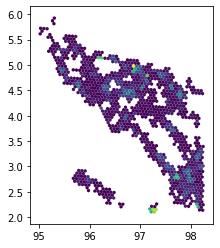

In [46]:
# convert h3 density upsampled data to h3 using h3ronpy
raster_path = def_upsampled_area
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]
gdf.head()

In [47]:
#zonal statistics in area
zs_ = zonal_stats(gdf,
            def_upsampled_area,
            stats="sum")

In [48]:
def_ha = []
for el in zs_:
    if el['sum']!=None:
        ha_ = float(el['sum'])
    else:
        ha_ = 0
    def_ha.append(ha_)
gdf['def_ha']=def_ha
gdf.head()

,h3index,value,geometry,def_ha
0,866554637ffffff,1.065256,"POLYGON ((96.47791 4.05650, 96.48070 4.09286, ...",1.065256
1,86655471fffffff,1.065256,"POLYGON ((96.50546 3.99961, 96.50824 4.03595, ...",0.000000
2,86655652fffffff,1.311428,"POLYGON ((97.25309 4.98671, 97.25597 5.02316, ...",0.000000
3,866556cdfffffff,1.311428,"POLYGON ((97.21699 4.93445, 97.21986 4.97090, ...",1.311428
4,866550087ffffff,29.625748,"POLYGON ((95.82055 4.65438, 95.82327 4.69081, ...",29.625748


In [49]:
#export to explore in QGIS:
gdf.to_file("../../datasets/processed/Satelligence_data/upsampled_area_zonal_statistics_h3.shp")

In [51]:
#¢ompute the area in the mills to check that we have exactly the same results


def_list = []
for index in list(gd_mills['index'].unique()):
    #filter gdf
    mills_h3 = list(gd_mills[gd_mills['index']==index]['h3_polyfil'])
    sum_ = gdf[gdf['h3index'].isin(mills_h3)]['def_ha'].sum()
    def_list.append(sum_)


# Check with rubber production

## 1- Raster:

In [138]:
# rubber dataset
rubber_path = '../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production.tif'

In [7]:
#zonal stats original raster
zs_rubber = buffer_stats(rubber_path,
             mill_point,
             buffer=50000,
             stat_='sum')

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [8]:
zs_rubber

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),5240.222168
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),6110.638184
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),6567.220703
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),7056.676758
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),8573.869141
5,6.0,1851,PO1000010059,UNKNOWN,SINGKIL SEJAHTERA MAKMUR,SINGKIL SEJAHTERA MAKMUR,Not RSPO Certified,None,2021-07-14,2.462277,...,Aceh Singkil,3-Low Confidence,None,0,e88f2c85-d320-d16b-4521-5199adec82cf,646.2566888648132,494.7889486397643,113174.4700961844,POINT (98.02821 2.46228),8459.148438
6,7.0,1412,PO1000007625,UNKNOWN,RUNDING PUTRA PERSADA,RUNDING PUTRA PERSADA,Not RSPO Certified,None,2021-07-14,2.46267,...,Aceh Singkil,1-Fully Verified,None,0,868d7819-4270-a666-e64f-bcc877ed8326,703.6551788812438,551.9323143633895,124408.0447707502,POINT (97.93961 2.46267),7624.793945
7,8.0,1653,PO1000008422,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 2,Not RSPO Certified,None,2021-07-14,2.56063,...,Aceh Singkil,1-Fully Verified,None,0,d1304c50-563f-5e26-866c-9c47e8651c87,830.1162625465768,678.5813843497369,149931.9770237909,POINT (97.94867 2.56063),8834.505859
8,9.0,1697,PO1000008583,UNKNOWN,BUMI DAYA AGROTAMAS,BUMI DAYA AGROTAMAS,Not RSPO Certified,None,2021-07-14,2.583222,...,Subulussalam,1-Fully Verified,None,0,7e91bbe2-7b15-6da8-38ea-d5093167d101,744.4213553526763,672.9194153953714,135059.8957749358,POINT (97.85417 2.58322),8116.541992
9,10.0,1429,PO1000007646,UNKNOWN,GLOBAL SAWIT SEMESTA,SUBULUSSALAM,Not RSPO Certified,None,2021-07-14,2.62,...,Subulussalam,1-Fully Verified,None,0,6551eabb-2cbd-c33b-74b7-7ebabe6f4913,888.7098084608854,737.3136820724134,161829.3224461289,POINT (98.03000 2.62000),10278.111328


In [139]:
#zonal stats original raster
zs_rubber = buffer_stats(rubber_path,
             mill_point,
             buffer=50000,
             stat_='sum',
            all_touched = False)
zs_rubber.head()

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),4361.949219
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),5004.427734
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),5742.597168
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),5598.906250
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),7473.239746


## 2. H3Ronpy:

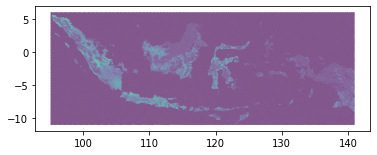

In [55]:
# convert h3 density upsampled data to h3 using h3ronpy

resolution = 6 
raster_path = '../../datasets/raw/qa_values/rubber_production_clip.tif'

with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]

location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf[gdf['h3index'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

## 3. H3:

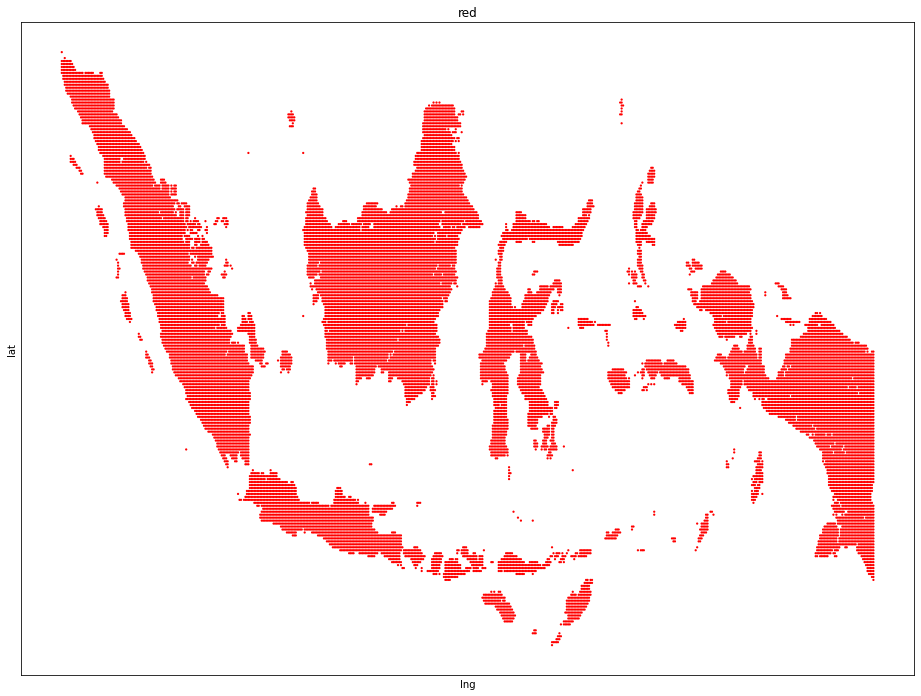

In [5]:
df = (rxr.open_rasterio('../../datasets/raw/qa_values/rubber_production_clip.tif')
       .sel(band=1)
       .to_pandas()
       .stack()
       .reset_index()
       .rename(columns={'x': 'lng', 'y': 'lat', 0: 'prod'}))
# ignore the 0 values
df = df[df['prod']>0]

# Visualize the deforestation mas
plot_scatter(df, metric_col='red', marker='.', colormap='gray')
#df.head()

As we are having error of the same magnitud, we can explore in detail how the tranlation between raster to h3 is done. As the first step is to convert the raster to point data, we can see if the values that we are getting there at the point level are the same as the ones that we have on the rasters. 



In [38]:
geometry = []
for i, row in df.iterrows():
    lat = row['lat']
    lng = row['lng']
    geom = Point(lng,lat)
    geometry.append(geom)
df['geometry'] = geometry
df = df.set_geometry('geometry')
df = df.set_crs('epsg:4326')
    

In [39]:
#Export  to shapefile to check point in QGIS
df.to_file('../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production_points.shp')

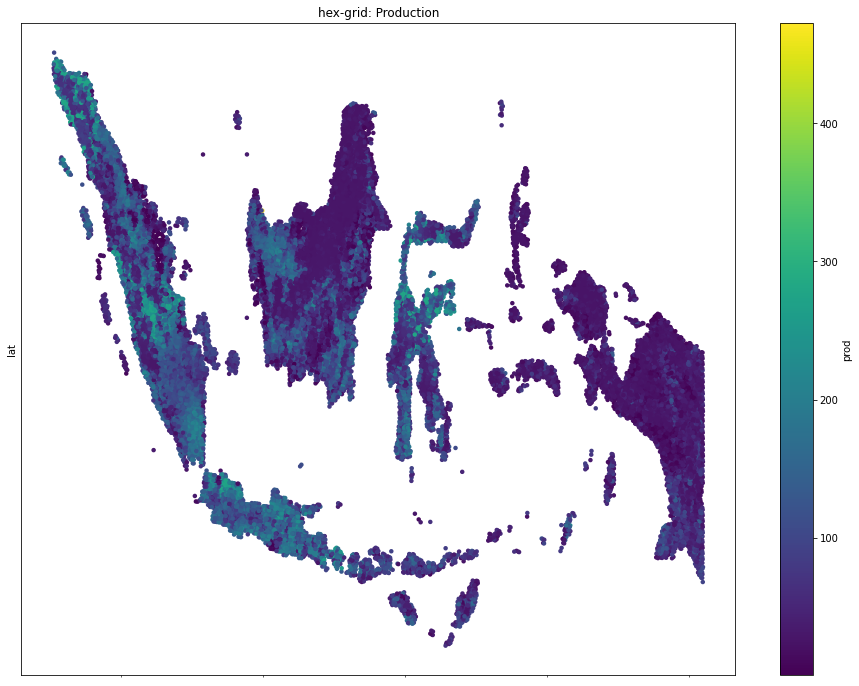

In [6]:
APERTURE_SIZE = 6
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# calculate elevation average per hex
df_ = df.groupby(hex_col)['prod'].mean().to_frame('prod').reset_index()

#find center of hex for visualization
df_['lat'] = df_[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_['lng'] = df_[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
df_['geometry'] =  df_[hex_col].apply(lambda x: {"type": "Polygon",
                   "coordinates":
                   [h3.h3_to_geo_boundary(
                       h=x, geo_json=True)]
                   })
df_["the_geom"] = df_["geometry"].apply(lambda x: shape(x))
# plot the hexes
plot_scatter(df_, metric_col='prod', marker='o')
plt.title('hex-grid: Production');

In [11]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_[df_['hex6'].isin(loc_indexes)]['prod'].sum()
    location_sum.append(sum_)

In [12]:
#expotr geodataframe to check it in qgis
df_ = df_.set_geometry('the_geom')
df_ = df_.set_crs('epsg:4326')
#df_.to_file('../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production_clip_h3lib.shp')
df_.head()

,hex6,prod,lat,lng,geometry,the_geom
0,86650824fffffff,152.222870,4.274142,98.186076,"{'type': 'Polygon', 'coordinates': [((98.21628...","POLYGON ((98.21628 4.25352, 98.21926 4.28987, ..."
1,86650826fffffff,71.872337,4.217175,98.213308,"{'type': 'Polygon', 'coordinates': [((98.24350...","POLYGON ((98.24351 4.19656, 98.24648 4.23290, ..."
2,8665082cfffffff,48.220238,4.435317,98.231158,"{'type': 'Polygon', 'coordinates': [((98.26137...","POLYGON ((98.26137 4.41468, 98.26435 4.45105, ..."
3,866508a27ffffff,76.553619,3.856067,98.629602,"{'type': 'Polygon', 'coordinates': [((98.65972...","POLYGON ((98.65972 3.83547, 98.66274 3.87176, ..."
4,866508a2fffffff,120.897346,3.860965,98.566335,"{'type': 'Polygon', 'coordinates': [((98.59646...","POLYGON ((98.59646 3.84037, 98.59947 3.87666, ..."


In [13]:
#clean dataframe
df_ = df_[['hex6','prod','the_geom']]
df_.head()

,hex6,prod,the_geom
0,86650824fffffff,152.222870,"POLYGON ((98.21628 4.25352, 98.21926 4.28987, ..."
1,86650826fffffff,71.872337,"POLYGON ((98.24351 4.19656, 98.24648 4.23290, ..."
2,8665082cfffffff,48.220238,"POLYGON ((98.26137 4.41468, 98.26435 4.45105, ..."
3,866508a27ffffff,76.553619,"POLYGON ((98.65972 3.83547, 98.66274 3.87176, ..."
4,866508a2fffffff,120.897346,"POLYGON ((98.59646 3.84037, 98.59947 3.87666, ..."


sum sanity check: 1.0000001


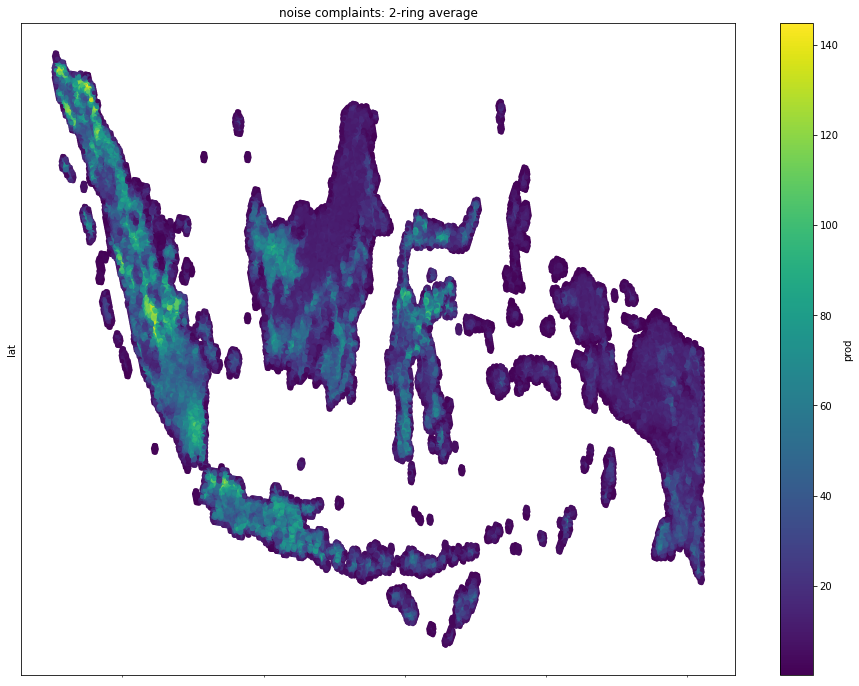

In [20]:
## apply krigging to smoth the results
k = 2
df_s= kring_smoothing(df_, 'hex6', metric_col='prod', k=k)
print('sum sanity check:', df_s['prod'].sum() / df_['prod'].sum())
plot_scatter(df_s, metric_col='prod', marker='o')
plt.title('noise complaints: 2-ring average');


In [22]:
df_s.head()

,hex6,prod,lat,lng,geometry,the_geom
0,866425967ffffff,3.027074,5.325898,97.375933,"{'type': 'Polygon', 'coordinates': [((97.40631...","POLYGON ((97.40631063611936 5.305220231171365,..."
1,86642c947ffffff,5.186474,5.916823,95.369525,"{'type': 'Polygon', 'coordinates': [((95.40009...","POLYGON ((95.40009033753243 5.896213661255948,..."
2,86642c94fffffff,5.186474,5.921481,95.305713,"{'type': 'Polygon', 'coordinates': [((95.33628...","POLYGON ((95.33628200718718 5.900874406296235,..."
3,86642c967ffffff,5.186474,5.859659,95.397410,"{'type': 'Polygon', 'coordinates': [((95.42796...","POLYGON ((95.4279691964128 5.839050171897558, ..."
4,86642c96fffffff,5.186474,5.864320,95.333609,"{'type': 'Polygon', 'coordinates': [((95.36417...",POLYGON ((95.36417146788165 5.8437142895297045...


In [23]:
#expotr geodataframe to check it in qgis
df_s = df_s.set_geometry('the_geom')
df_s = df_s.set_crs('epsg:4326')
df_s.to_file('../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production_clip_h3lib_s.shp')
#df_s.head()

In [24]:
# obtain production values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_s[df_s['hex6'].isin(loc_indexes)]['prod'].sum()
    location_sum.append(sum_)

<a id='ReplicatetheanalysisusingSatelligencedata:'></a>
# Replicate the analysis using Satelligence data:

## 1. Deforestation

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86650906fffffff,3.085363,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,..."
1,866509087ffffff,10.160213,4.142242,97.760754,"{'type': 'Polygon', 'coordinates': [((97.79098...","POLYGON ((97.79098927270533 4.121643547113218,..."
2,86650908fffffff,0.425207,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97..."
3,866509097ffffff,5.684348,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...
4,8665090a7ffffff,0.152179,4.085304,97.788063,"{'type': 'Polygon', 'coordinates': [((97.81828...","POLYGON ((97.81828960320078 4.064710085138689,..."


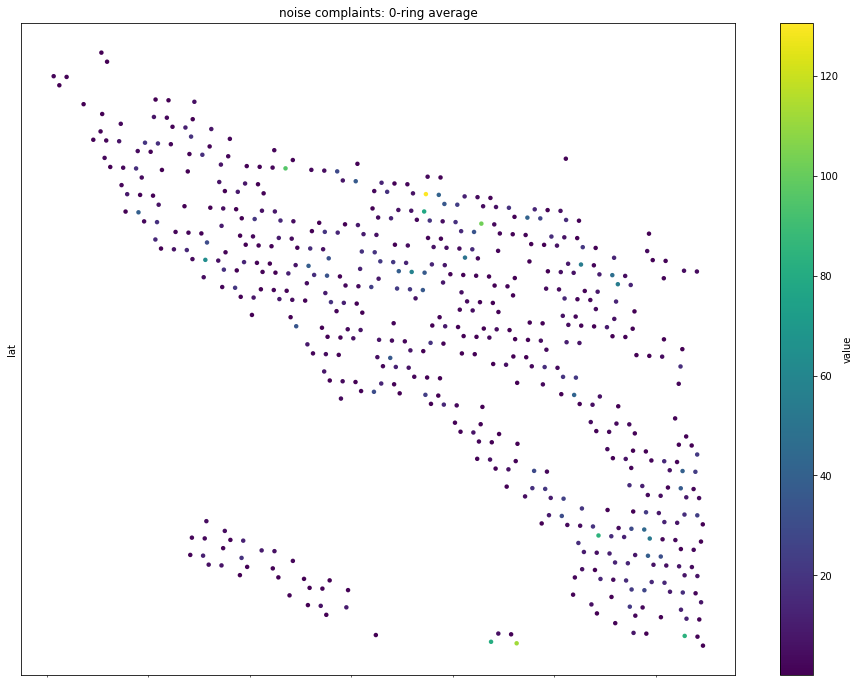

In [6]:
raste_path_deforestation_area_ha = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif"
df_d = tiff_to_smooth_h3(raster_path=raste_path_deforestation_area_ha,
                        h3_res=6, k=0)
plot_scatter(df_d, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_d.head()

In [7]:
# obtain deforestation values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_d[df_d['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

## 2. Carbon:
### a. Precalculated - ingest the carbon data precalculated:

Option 1 - ingest the satelligence carbon data precalculated. To precalculate the dataset we need to:

    1. donwsample the above ground biomass to the same resolution as the deforestation layer
    2. Multiply the donwsample above ground biomass layer times the deforestation layer
    3. Upsample the result before ingesting:

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86650906fffffff,554.520813,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,..."
1,866509087ffffff,1602.650391,4.142242,97.760754,"{'type': 'Polygon', 'coordinates': [((97.79098...","POLYGON ((97.79098927270533 4.121643547113218,..."
2,86650908fffffff,41.209286,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97..."
3,866509097ffffff,936.158386,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...
4,8665090a7ffffff,27.499712,4.085304,97.788063,"{'type': 'Polygon', 'coordinates': [((97.81828...","POLYGON ((97.81828960320078 4.064710085138689,..."


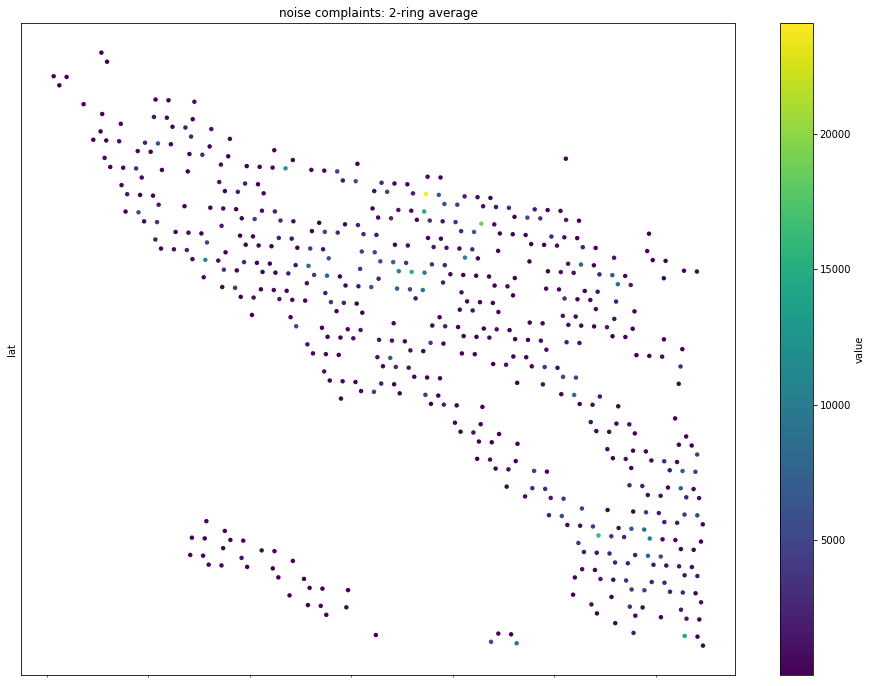

In [8]:
raste_path_precalculated_carbon = '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_sum_upsample.tif'
df_c = tiff_to_smooth_h3(raster_path=raste_path_precalculated_carbon,
                        h3_res=6, k=0)
plot_scatter(df_c, metric_col='value', marker='o')
plt.title('noise complaints: 2-ring average');
df_c.head()

In [9]:
# obtain production values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_c[df_c['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

### b. DDBB calculation - ingest the biomass dataset:

Option 2 - ingest the satelligence data directly to the ddbb and perform the calculation directly in the ddbb. To do so we need to:


    1. Upsample the above ground biomass prior ingestion

Once ingested we will need to multiply the above ground biomass layer and the deforestation layer to obtain the emissions:

In [127]:
#zonal statistics with the upsampled raster to check the error that we are getting on the upsampling and not on the h3 translation
raster_path_upsampled = '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_upsample.tif'

zs_carbon_upsampled = buffer_stats(raster_path_upsampled,
             mill_point,
             buffer=50000,
             stat_='sum')
zs_carbon_upsampled.head()

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),61336.0
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),71051.0
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),73711.0
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),75990.0
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),88893.0


In [129]:
#zonal statistics with the upsampled raster to check the error that we are getting on the upsampling and not on the h3 translation
raster_path_upsampled = '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif'

zs_carbon_raw = buffer_stats(raster_path_upsampled,
             mill_point,
             buffer=50000,
             stat_='sum')
zs_carbon_raw.head()

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),49993621.0
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),56917561.0
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),63755161.0
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),65408130.0
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),79263855.0


In [178]:
#zonal statistics with the upsampled raster to check the error that we are getting on the upsampling and not on the h3 translation
raster_path_upsampled_def = '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif'

zs_carbon_raw_def = buffer_stats(raster_path_upsampled_def,
             mill_point,
             buffer=50000,
             stat_='sum',
            all_touched = False)
zs_carbon_raw_def.head()

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),57793.746094
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),74415.992188
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),95535.335938
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),109531.187500
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),104951.414062


In [176]:
# multiply the def area upsampled and the biomass upsampled
#!gdal_calc.py --calc "A*B" --format GTiff --type Float32 -A '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_upsample.tif' --A_band 1 -B "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif" --outfile '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_upsampled_ddbb.tif'

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,866400017ffffff,1.0,9.950291,96.187230,"{'type': 'Polygon', 'coordinates': [((96.21812...","POLYGON ((96.21812531587884 9.929532445426124,..."
1,86640001fffffff,1.0,9.955065,96.122632,"{'type': 'Polygon', 'coordinates': [((96.15353...","POLYGON ((96.15353185176853 9.934312646085267,..."
2,86640002fffffff,1.0,9.844861,96.114250,"{'type': 'Polygon', 'coordinates': [((96.14513...","POLYGON ((96.14513996283267 9.824109243462395,..."
3,866400037ffffff,1.0,9.892799,96.215320,"{'type': 'Polygon', 'coordinates': [((96.24620...","POLYGON ((96.24620848778824 9.872037298099695,..."
4,866400047ffffff,1.0,9.854370,95.985092,"{'type': 'Polygon', 'coordinates': [((96.01599...","POLYGON ((96.01599069152249 9.833629578075957,..."


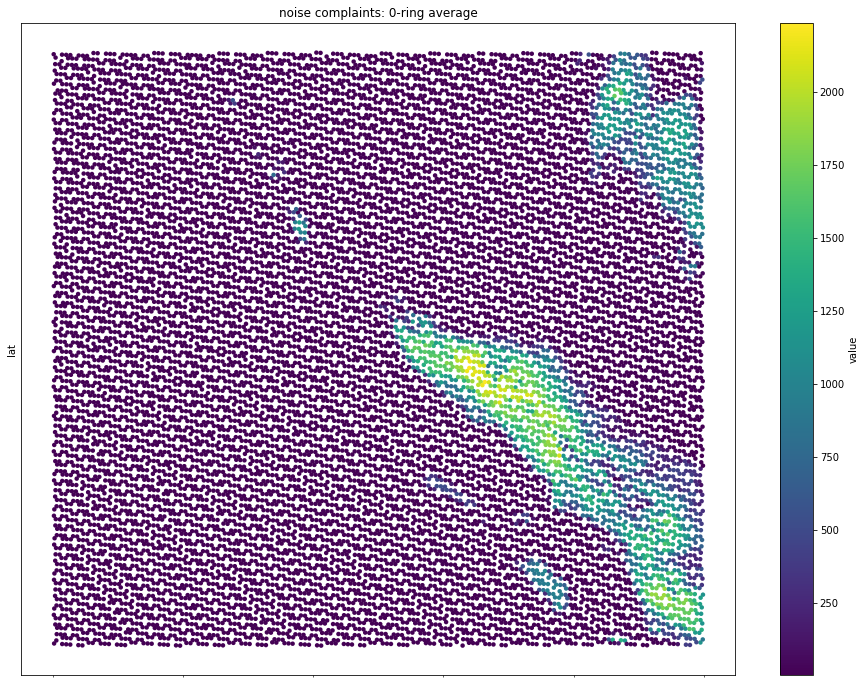

In [10]:
raste_path_carbon_biomass = '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_upsample.tif'
df_cb = tiff_to_smooth_h3(raster_path=raste_path_carbon_biomass,
                        h3_res=6, k=0)
plot_scatter(df_cb, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_cb.head()

In [11]:
df_merge = df_d.merge(df_cb,
    how='inner',
    on='hex6')
df_merge.head()

,hex6,value_x,lat_x,lng_x,geometry_x,the_geom_x,value_y,lat_y,lng_y,geometry_y,the_geom_y
0,86650906fffffff,3.085363,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,...",1970.0,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,..."
1,86650908fffffff,0.425207,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97...",1471.0,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97..."
2,866509097ffffff,5.684348,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...,1329.0,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...
3,8665090d7ffffff,1.190580,4.151936,97.633947,"{'type': 'Polygon', 'coordinates': [((97.66419...","POLYGON ((97.6641938331346 4.131341003176351, ...",1539.0,4.151936,97.633947,"{'type': 'Polygon', 'coordinates': [((97.66419...","POLYGON ((97.6641938331346 4.131341003176351, ..."
4,8665090e7ffffff,6.915211,4.042910,97.625218,"{'type': 'Polygon', 'coordinates': [((97.65545...","POLYGON ((97.65545598663725 4.022324324663226,...",1719.0,4.042910,97.625218,"{'type': 'Polygon', 'coordinates': [((97.65545...","POLYGON ((97.65545598663725 4.022324324663226,..."


In [12]:
carbon_loss_T = []
for i, row in df_merge.iterrows():
    def_area = row['value_x']
    biomass = row['value_y']
    carbon_loss = def_area*biomass
    carbon_loss_T.append(carbon_loss)
df_merge['value'] = carbon_loss_T
df_merge = df_merge[['hex6', 'value']]
df_merge.head()

,hex6,value
0,86650906fffffff,6078.164465
1,86650908fffffff,625.479700
2,866509097ffffff,7554.498633
3,8665090d7ffffff,1832.302636
4,8665090e7ffffff,11887.247234


In [13]:
# obtain production values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_merge[df_merge['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

## 3. Biodiversity:
### 3-a Species richness:

Procedure 

    1. Identify pixels in biodiversity layer with “high density of species”(threshold tbd) 
    2. Pair Indicator 1 with “high species density” and determine the area (in ha) of high biodiversity area lost 
    3. Additionally provide the area (ha) of (critically) endangered species loss 4. Use the same methodology as in indicator 1 to determine per mill biodiversity loss and compare with other mills inside/outside supply chain of company X.
    
SPECIES_RICHNESS_THRESHOLD = 264

### a. Precalculated

Obtain the biodiversity loss (high species richness area) prior ingestion. THe steps are: 

1. Get high species richness by filtering the dataset by the species richness threshold (264)
2. Generate mask of high species richness
3. downsample to the same resolution as the deforestation datasets
4. MUltiply the mask by the deforestation dataset to obtain deforestation taking place in high species richness areas

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86650906fffffff,3.085363,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,..."
1,866509087ffffff,10.160213,4.142242,97.760754,"{'type': 'Polygon', 'coordinates': [((97.79098...","POLYGON ((97.79098927270533 4.121643547113218,..."
2,86650908fffffff,0.425207,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97..."
3,866509097ffffff,5.684348,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...
4,8665090a7ffffff,0.152179,4.085304,97.788063,"{'type': 'Polygon', 'coordinates': [((97.81828...","POLYGON ((97.81828960320078 4.064710085138689,..."


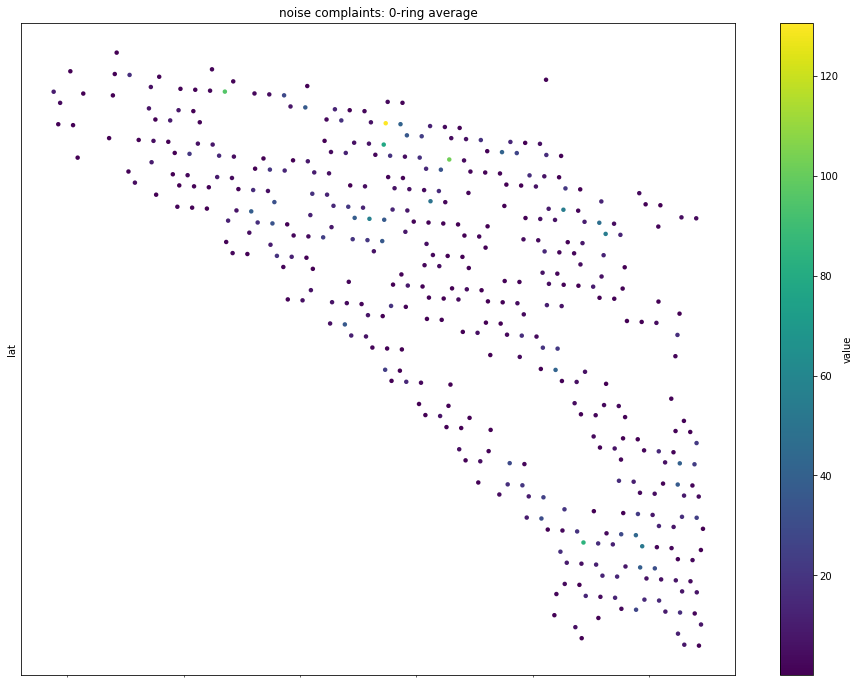

In [16]:
biodiversity_precalculated = '../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha_upsample.tif'
df_bp = tiff_to_smooth_h3(raster_path=biodiversity_precalculated,
                        h3_res=6, k=0)
plot_scatter(df_bp, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_bp.head()

In [17]:
# obtain biodiversity loss values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_bp[df_bp['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

In [ ]:
#zonal statistics with the upsampled raster to check the error that we are getting on the upsampling and not on the h3 translation
raster_path_upsampled_def = '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif'

zs_carbon_raw_def = buffer_stats(raster_path_upsampled_def,
             mill_point,
             buffer=50000,
             stat_='sum',
            all_touched = False)
zs_carbon_raw_def.head()

### b . DDBB Calculation

Obtain the biodiversity loss (high species richness area) in the ddbb. THe spetps would be:

1. 1. Get high species richness by filtering the dataset by the species richness threshold (264)
2. Generate mask of high species richness
3. Ingest the mask

Once the data has been ingested, we just need to multiply the deforestation h3 dataset by the high species richness mask:

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86650824fffffff,1.0,4.274142,98.186076,"{'type': 'Polygon', 'coordinates': [((98.21628...","POLYGON ((98.21628172852529 4.253521129846656,..."
1,866508257ffffff,1.0,4.321326,98.285621,"{'type': 'Polygon', 'coordinates': [((98.31582...","POLYGON ((98.31582149648644 4.300697780568773,..."
2,86650825fffffff,1.0,4.326226,98.222230,"{'type': 'Polygon', 'coordinates': [((98.25243...","POLYGON ((98.25243747308566 4.305599373077682,..."
3,866508277ffffff,1.0,4.264349,98.312837,"{'type': 'Polygon', 'coordinates': [((98.34302...",POLYGON ((98.34302968947749 4.2437249261549015...
4,8665082c7ffffff,1.0,4.430409,98.294569,"{'type': 'Polygon', 'coordinates': [((98.32477...","POLYGON ((98.3247781575961 4.409771285946085, ..."


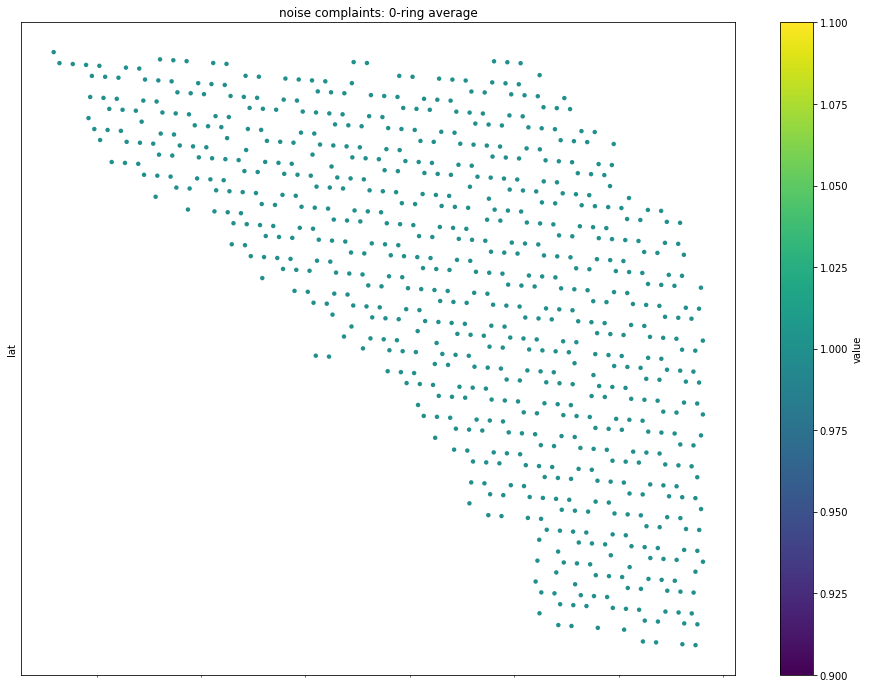

In [19]:
biodiversity_high_density = '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask_upsample.tif'
df_bhd = tiff_to_smooth_h3(raster_path=biodiversity_high_density,
                        h3_res=6, k=0)
plot_scatter(df_bhd, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_bhd.head()

In [21]:
df_merge = df_d.merge(df_bhd,
    how='inner',
    on='hex6')
df_merge.head()

,hex6,value_x,lat_x,lng_x,geometry_x,the_geom_x,value_y,lat_y,lng_y,geometry_y,the_geom_y
0,86650908fffffff,0.425207,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97...",1.0,4.147091,97.697353,"{'type': 'Polygon', 'coordinates': [((97.72759...","POLYGON ((97.727594389654 4.12649460518133, 97..."
1,866509097ffffff,5.684348,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...,1.0,4.194336,97.796845,"{'type': 'Polygon', 'coordinates': [((97.82708...",POLYGON ((97.82708090355949 4.1737327064929906...
2,8665090a7ffffff,0.152179,4.085304,97.788063,"{'type': 'Polygon', 'coordinates': [((97.81828...","POLYGON ((97.81828960320078 4.064710085138689,...",1.0,4.085304,97.788063,"{'type': 'Polygon', 'coordinates': [((97.81828...","POLYGON ((97.81828960320078 4.064710085138689,..."
3,8665090d7ffffff,1.190580,4.151936,97.633947,"{'type': 'Polygon', 'coordinates': [((97.66419...","POLYGON ((97.6641938331346 4.131341003176351, ...",1.0,4.151936,97.633947,"{'type': 'Polygon', 'coordinates': [((97.66419...","POLYGON ((97.6641938331346 4.131341003176351, ..."
4,8665090dfffffff,4.778731,4.156777,97.570534,"{'type': 'Polygon', 'coordinates': [((97.60078...","POLYGON ((97.60078775766749 4.136182722118971,...",1.0,4.156777,97.570534,"{'type': 'Polygon', 'coordinates': [((97.60078...","POLYGON ((97.60078775766749 4.136182722118971,..."


In [23]:
biodiversity_loss_ha = []
for i, row in df_merge.iterrows():
    def_area = row['value_x']
    bio_high_dens = row['value_y']
    area_loss = def_area*bio_high_dens
    biodiversity_loss_ha.append(area_loss)
df_merge['value'] = biodiversity_loss_ha
df_merge = df_merge[['hex6', 'value']]
df_merge.head()

,hex6,value
0,86650908fffffff,0.425207
1,866509097ffffff,5.684348
2,8665090a7ffffff,0.152179
3,8665090d7ffffff,1.190580
4,8665090dfffffff,4.778731


In [24]:
# obtain forest loss in high density of species area values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_merge[df_merge['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

### 3-b. WDPA:


###  Raster calculation - replicate satelligence analysis:

In [41]:
#downsample to same resolution as deforestation layer
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 6e-05 6e-05 -r near -te 94.99998 2.1 98.29998 6.10002 -te_srs EPSG:4326 -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif' '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled.tif'


Creating output file that is 55000P x 66667L.
Processing ../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [43]:
# multiply deforestation times wdpa layer
!gdal_calc.py --calc "A*B*(A>0)" --format GTiff --type Float32 -A '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled.tif' --A_band 1 -B '../../datasets/processed/Satelligence_data/test_rasters_2/Deforestation_2021_2022_area_ha.tif' --outfile '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled_v2.tif'


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 

11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 

16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 

21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 

26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 

36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 

41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 

51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 

56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 

60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 

65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 

70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 

75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 

80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 

85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 

95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 

In [44]:
gdf= buffer_stats(
    '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled_v2.tif',
    '../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point_updated.shp',
    buffer=50000,
    stat_='sum')

gdf.head()

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,high_biodi,protected_,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,4.099892144030757,57812.37323319753,POINT (98.02851 2.24508),4.099891
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,11.27470339608458,74432.2796810086,POINT (97.99572 2.31416),11.274702
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,14.50180190683368,95543.40760696075,POINT (97.95667 2.39111),14.501802
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,22.19581347407044,109557.3760590317,POINT (97.91529 2.43594),22.195827
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,11.4179310692385,104970.0756673934,POINT (98.06502 2.45678),11.417932


In [45]:
# export
gdf.to_csv('../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_mills_zonal_statistics.csv')

### a. Precalculated h3ronpy
The steps should be similar to the biodiversity loss one:

    1. Downsample the protected area layer to the same resolution as the deforestation layer
    2. Multiply the two datasets ( protected area with deforestation)
    3. Upsample the datasets and ingest

In [46]:
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled_v2.tif' '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled.tif'

Creating output file that is 40P x 48L.
Processing ../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled_v2.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_downsampled_v2.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,biodiversi,geometry,estimate
0,706,200.138293908663,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",12.902925
1,717,295.5592552826714,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",21.309589
2,264,400.8360709155834,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",35.906883
3,738,469.4242228971635,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",63.333984
4,1516,448.9605690952982,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",24.810211


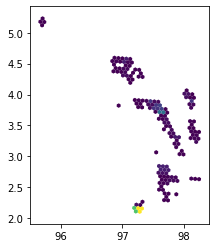

In [50]:
gdf_res6 = convert_raster_h3('../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled.tif', 
                  '../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp',
                  column='biodiversi',
                  resolution=6)
gdf_res6.head()

### b. Precalculated h3s

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86650906fffffff,3.085363,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,..."
1,86650914fffffff,21.600025,3.824983,97.607778,"{'type': 'Polygon', 'coordinates': [((97.63799...","POLYGON ((97.63799735751756 3.804416965824351,..."
2,866509307ffffff,1.714256,3.896322,97.390348,"{'type': 'Polygon', 'coordinates': [((97.42059...","POLYGON ((97.4205931573665 3.875755599303177, ..."
3,866509337ffffff,17.315628,3.891507,97.453722,"{'type': 'Polygon', 'coordinates': [((97.48396...","POLYGON ((97.48396151419881 3.870938850174882,..."
4,866509357ffffff,0.613193,3.905939,97.263585,"{'type': 'Polygon', 'coordinates': [((97.29384...","POLYGON ((97.29384184879342 3.885375854766318,..."


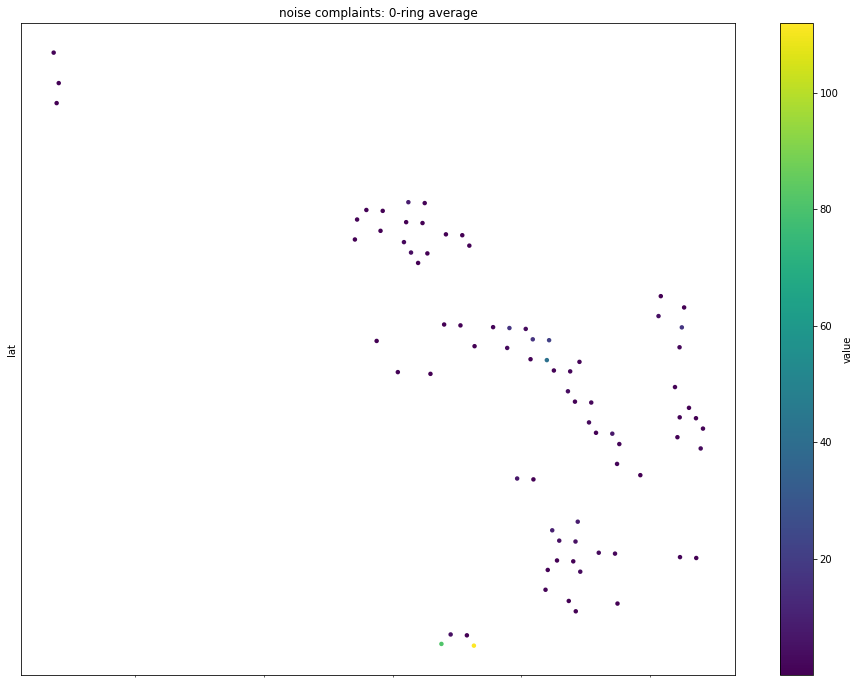

In [53]:
biodiversity_wdpa = '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled.tif'
df_bwdpa = tiff_to_smooth_h3(raster_path=biodiversity_wdpa,
                        h3_res=6, k=0)
plot_scatter(df_bwdpa, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_bwdpa.head()

In [55]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_bwdpa[df_bwdpa['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

### c. DDBB Calculation h3s

The steps would be to upsample the wdpa dataset and multiply by the deforestation area before getting the statistics:

In [59]:
## upsample the carbon_loss_T for ingesting
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r max  -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif' '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled_ddbb_v2.tif'

Creating output file that is 40P x 48L.
Processing ../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [118]:
## instead of mask (0-1), get the wdpa as proportion (density)
#get count of pixels with protected area
#!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021-01-01-2022-01-01.tif' '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled_ddbb_sum_v1.tif'
# multiply deforestation times wdpa layer
!gdal_calc.py --calc "A/1178.3769531" --format GTiff --type Float32 --NoDataValue 0.0 -A '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled_ddbb_sum_v1.tif' --A_band 1 --outfile '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_density_v5.tif'


0.. 100 - Done


sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86642c947ffffff,1.0,5.916823,95.369525,"{'type': 'Polygon', 'coordinates': [((95.40009...","POLYGON ((95.40009033753243 5.896213661255948,..."
1,866509007ffffff,1.0,3.981156,97.715918,"{'type': 'Polygon', 'coordinates': [((97.74614...","POLYGON ((97.74614235636871 3.960573258095429,..."
2,86650900fffffff,1.0,3.985995,97.652545,"{'type': 'Polygon', 'coordinates': [((97.68277...",POLYGON ((97.68277497978869 3.9654132624513942...
3,866509037ffffff,1.0,3.976313,97.779286,"{'type': 'Polygon', 'coordinates': [((97.80950...",POLYGON ((97.80950401997592 3.9557288050561414...
4,86650905fffffff,1.0,3.995659,97.525781,"{'type': 'Polygon', 'coordinates': [((97.55602...","POLYGON ((97.556023704855 3.9750798495350965, ..."


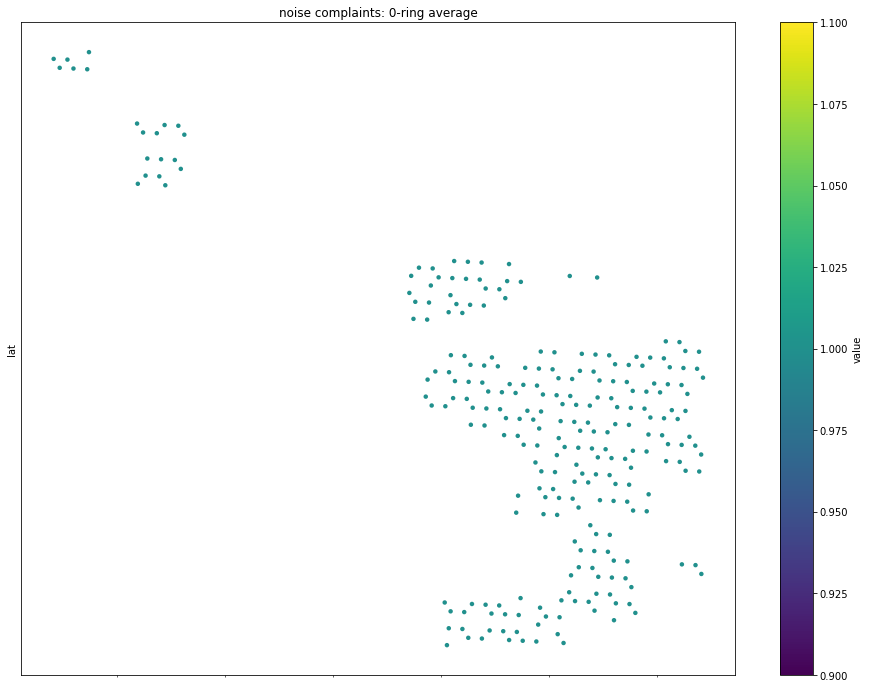

In [81]:
biodiversity_wdpa_upsampled = '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled_ddbb_v2.tif'
df_bwdpa_ddbb = tiff_to_smooth_h3(raster_path=biodiversity_wdpa_upsampled,
                        h3_res=6, k=0)
plot_scatter(df_bwdpa_ddbb, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_bwdpa_ddbb.head()

sum sanity check: 1.0


,hex6,value,lat,lng,geometry,the_geom
0,86642c947ffffff,0.332842,5.916823,95.369525,"{'type': 'Polygon', 'coordinates': [((95.40009...","POLYGON ((95.40009033753243 5.896213661255948,..."
1,866509007ffffff,0.225821,3.981156,97.715918,"{'type': 'Polygon', 'coordinates': [((97.74614...","POLYGON ((97.74614235636871 3.960573258095429,..."
2,86650900fffffff,0.266272,3.985995,97.652545,"{'type': 'Polygon', 'coordinates': [((97.68277...",POLYGON ((97.68277497978869 3.9654132624513942...
3,866509037ffffff,0.148459,3.976313,97.779286,"{'type': 'Polygon', 'coordinates': [((97.80950...",POLYGON ((97.80950401997592 3.9557288050561414...
4,86650905fffffff,0.184753,3.995659,97.525781,"{'type': 'Polygon', 'coordinates': [((97.55602...","POLYGON ((97.556023704855 3.9750798495350965, ..."


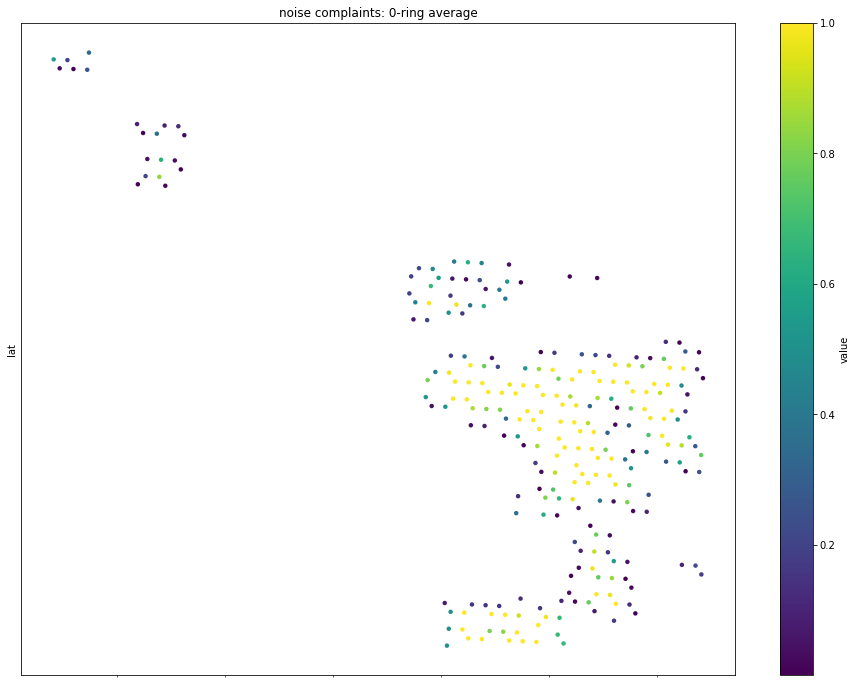

In [119]:
biodiversity_wdpa_upsampled_Density = '../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_density_v5.tif'
df_bwdpa_ddbb_density = tiff_to_smooth_h3(raster_path=biodiversity_wdpa_upsampled_Density,
                        h3_res=6, k=0)
plot_scatter(df_bwdpa_ddbb_density, metric_col='value', marker='o')
plt.title('noise complaints: 0-ring average');
df_bwdpa_ddbb_density.head()

In [82]:
df_bwdpa_ddbb = df_bwdpa_ddbb.set_geometry('the_geom')
df_bwdpa_ddbb = df_bwdpa_ddbb.set_crs('EPSG:4326')
df_bwdpa_ddbb.to_file('../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_k0.shp')

In [120]:
#df_merge = df_d.merge(df_bwdpa_ddbb,
#    how='inner',
#    on='hex6')
#df_merge.head()

df_merge = df_d.merge(df_bwdpa_ddbb_density,
    how='inner',
    on='hex6')
df_merge.head()

,hex6,value_x,lat_x,lng_x,geometry_x,the_geom_x,value_y,lat_y,lng_y,geometry_y,the_geom_y
0,86650906fffffff,3.085363,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,...",1.000000,3.886687,97.517092,"{'type': 'Polygon', 'coordinates': [((97.54732...","POLYGON ((97.54732480012483 3.866117711655502,..."
1,86650914fffffff,21.600025,3.824983,97.607778,"{'type': 'Polygon', 'coordinates': [((97.63799...","POLYGON ((97.63799735751756 3.804416965824351,...",0.999518,3.824983,97.607778,"{'type': 'Polygon', 'coordinates': [((97.63799...","POLYGON ((97.63799735751756 3.804416965824351,..."
2,8665091a7ffffff,0.098469,3.966613,97.906004,"{'type': 'Polygon', 'coordinates': [((97.93620...","POLYGON ((97.93620959162948 3.946026628771798,...",0.100295,3.966613,97.906004,"{'type': 'Polygon', 'coordinates': [((97.93620...","POLYGON ((97.93620959162948 3.946026628771798,..."
3,866509247ffffff,0.948883,3.972433,97.109384,"{'type': 'Polygon', 'coordinates': [((97.13965...",POLYGON ((97.13965948945355 3.9518682689041875...,0.400458,3.972433,97.109384,"{'type': 'Polygon', 'coordinates': [((97.13965...",POLYGON ((97.13965948945355 3.9518682689041875...
4,86650924fffffff,0.371497,3.977226,97.045975,"{'type': 'Polygon', 'coordinates': [((97.07625...","POLYGON ((97.0762557760929 3.9566628085439, 97...",0.178883,3.977226,97.045975,"{'type': 'Polygon', 'coordinates': [((97.07625...","POLYGON ((97.0762557760929 3.9566628085439, 97..."


In [121]:
biodiversity_loss_ha_wdpa = []
for i, row in df_merge.iterrows():
    def_area = row['value_x']
    bio_high_dens = row['value_y']
    area_loss = def_area*bio_high_dens
    biodiversity_loss_ha_wdpa.append(area_loss)
df_merge['value'] = biodiversity_loss_ha_wdpa
df_merge = df_merge[['hex6', 'value']]
df_merge.head()

,hex6,value
0,86650906fffffff,3.085363
1,86650914fffffff,21.589610
2,8665091a7ffffff,0.009876
3,866509247ffffff,0.379988
4,86650924fffffff,0.066454


In [122]:
# obtain forest loss in high density of species area values using krigging
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = df_merge[df_merge['hex6'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

### d. DDBB Calculation h3ronpy:

,h3index,value,geometry
0,0x86642c947ffffff,1.0,"POLYGON ((95.40009 5.89621, 95.40277 5.93277, ..."
1,0x86642c94fffffff,1.0,"POLYGON ((95.33628 5.90087, 95.33896 5.93743, ..."
2,0x86642c967ffffff,1.0,"POLYGON ((95.42797 5.83905, 95.43065 5.87560, ..."
3,0x86642c96fffffff,1.0,"POLYGON ((95.36417 5.84371, 95.36685 5.88027, ..."
4,0x866509007ffffff,1.0,"POLYGON ((97.74614 3.96057, 97.74906 3.99690, ..."


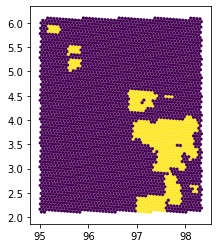

In [87]:
raster_path='../../datasets/processed/Satelligence_data/biodiversity_wdpa/WDPA_IDN_2021_upsampled_ddbb_v2.tif'
with rio.open(raster_path) as src:
    gdf_wdpa6 = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=6, compacted=False)
    gdf_wdpa6.plot('value')
    gdf_wdpa6['h3index'] = gdf_wdpa6['h3index'].apply(hex)
gdf_wdpa6.head()

,h3index,value,geometry
0,0x8665569a7ffffff,1.682925,"POLYGON ((97.30093 4.37854, 97.30381 4.41492, ..."
1,0x866509307ffffff,2.895884,"POLYGON ((97.42059 3.87576, 97.42348 3.91208, ..."
2,0x866552937ffffff,28.601768,"POLYGON ((96.46205 5.10150, 96.46484 5.13798, ..."
3,0x86655664fffffff,28.601768,"POLYGON ((96.49807 5.15383, 96.50086 5.19031, ..."
4,0x86655666fffffff,28.601768,"POLYGON ((96.52570 5.09673, 96.52850 5.13320, ..."


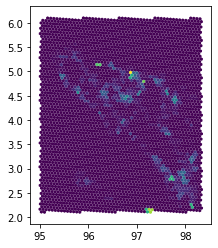

In [88]:
raster_path="../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif"
with rio.open(raster_path) as src:
    gdf_def6 = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=6, compacted=False)
    gdf_def6.plot('value')
    gdf_def6['h3index'] = gdf_def6['h3index'].apply(hex)
gdf_def6.head()

In [92]:
gdf_merge = gdf_def6.merge(gdf_wdpa6,
    on='h3index',
    how='inner')
gdf_merge.head()

,h3index,value_x,geometry_x,value_y,geometry_y
0,0x8665569a7ffffff,1.682925,"POLYGON ((97.30093 4.37854, 97.30381 4.41492, ...",1.0,"POLYGON ((97.30093 4.37854, 97.30381 4.41492, ..."
1,0x866509307ffffff,2.895884,"POLYGON ((97.42059 3.87576, 97.42348 3.91208, ...",1.0,"POLYGON ((97.42059 3.87576, 97.42348 3.91208, ..."
2,0x866552937ffffff,28.601768,"POLYGON ((96.46205 5.10150, 96.46484 5.13798, ...",0.0,"POLYGON ((96.46205 5.10150, 96.46484 5.13798, ..."
3,0x86655664fffffff,28.601768,"POLYGON ((96.49807 5.15383, 96.50086 5.19031, ...",0.0,"POLYGON ((96.49807 5.15383, 96.50086 5.19031, ..."
4,0x86655666fffffff,28.601768,"POLYGON ((96.52570 5.09673, 96.52850 5.13320, ...",0.0,"POLYGON ((96.52570 5.09673, 96.52850 5.13320, ..."


In [93]:
index_list = []
area_wdpa_loss = []
for i, row in gdf_merge.iterrows():
    index = row['h3index'].split('x')[1]
    index_list.append(index)
    wdpa = row['value_y']
    def_area = row['value_x']
    wdpa_area = wdpa*def_area
    area_wdpa_loss.append(wdpa_area)
gdf_merge['h3index'] =  index_list
gdf_merge['value'] = area_wdpa_loss
gdf_merge = gdf_merge[['h3index', 'value']]
gdf_merge.head()

,h3index,value
0,8665569a7ffffff,1.682925
1,866509307ffffff,2.895884
2,866552937ffffff,0.000000
3,86655664fffffff,0.000000
4,86655666fffffff,0.000000


In [94]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf_merge[gdf_merge['h3index'].isin(loc_indexes)]['value'].sum()
    location_sum.append(sum_)

In [ ]:
## NOTE: PLAY WITH THE KRIGGING FOR THOSE MASK LAYERS AND THE DDBB CALCULATIONS
NOTE: NO INGEST THE WDPA AS MAX IN THE RESAMPLING. Change the resampling to density.

<a id='pixelarearatio:'></a>
# Pixel - h3 index area ratio:

## Rubber production:

,h3index,value,geometry
0,868cb359fffffff,4.174938,"POLYGON ((109.99529 -0.64417, 109.99929 -0.609..."
1,86688c887ffffff,8.488504,"POLYGON ((116.65504 1.10337, 116.65058 1.06963..."
2,86688c88fffffff,8.488504,"POLYGON ((116.70983 1.09370, 116.70537 1.05995..."
3,86688c89fffffff,8.488504,"POLYGON ((116.67574 1.04793, 116.67128 1.01419..."
4,866881c0fffffff,27.364521,"POLYGON ((115.55773 0.63005, 115.56210 0.66380..."


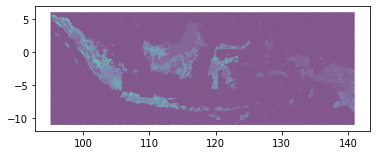

In [149]:
# convert production raster to h3 using h3ronpy:
# convert h3 density upsampled data to h3 using h3ronpy

resolution = 6 
raster_path = '../../datasets/raw/qa_values/rubber_production_clip.tif'

with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]

gdf.head()
#location_sum = []
#for index in gd_mills['index'].unique():
#    #filter dataframe and get h3 indexes
#    gdf_f = gd_mills[gd_mills['index']==index]
#    loc_indexes = list(gdf_f['h3_polyfil'])
#    sum_ = gdf[gdf['h3index'].isin(loc_indexes)]['value'].sum()
#    location_sum.append(sum_)

In [152]:
#obtain area for each hexagon
hex_area_list = []
for i, row in gdf.iterrows():
    hex_area = h3.cell_area(row['h3index'])
    hex_area_list.append(hex_area)

gdf['hex_area_km2'] = hex_area_list
gdf.head()

,h3index,value,geometry,hex_area_km2
0,868cb359fffffff,4.174938,"POLYGON ((109.99529 -0.64417, 109.99929 -0.609...",37.929748
1,86688c887ffffff,8.488504,"POLYGON ((116.65504 1.10337, 116.65058 1.06963...",35.077491
2,86688c88fffffff,8.488504,"POLYGON ((116.70983 1.09370, 116.70537 1.05995...",35.115459
3,86688c89fffffff,8.488504,"POLYGON ((116.67574 1.04793, 116.67128 1.01419...",35.085508
4,866881c0fffffff,27.364521,"POLYGON ((115.55773 0.63005, 115.56210 0.66380...",35.197107


In [159]:
# zonal statistics to get the pixel area
area_raster_km2 = '../../datasets/processed/Satelligence_data/area_ratio/8_Areakm.tif'
stats = zonal_stats(gdf,
                    area_raster_km2,
                    stats='max',
                    all_touched = True
            )

In [162]:
gdf['pix_area_km2'] = [el['max'] for el in stats]
gdf.head()

,h3index,value,geometry,hex_area_km2,pix_area_km2
0,868cb359fffffff,4.174938,"POLYGON ((109.99529 -0.64417, 109.99929 -0.609...",37.929748,86.050499
1,86688c887ffffff,8.488504,"POLYGON ((116.65504 1.10337, 116.65058 1.06963...",35.077491,86.041298
2,86688c88fffffff,8.488504,"POLYGON ((116.70983 1.09370, 116.70537 1.05995...",35.115459,86.041298
3,86688c89fffffff,8.488504,"POLYGON ((116.67574 1.04793, 116.67128 1.01419...",35.085508,86.043503
4,866881c0fffffff,27.364521,"POLYGON ((115.55773 0.63005, 115.56210 0.66380...",35.197107,86.050499


In [163]:
ratio_list = []
value_density_list = []
for i, row in gdf.iterrows():
    ratio = row['hex_area_km2']/row['pix_area_km2']
    ratio_list.append(ratio)
    value_density = row['value']*ratio
    value_density_list.append(value_density)
gdf['ratio'] = ratio_list
gdf['val_dens'] = value_density_list
gdf.head()

,h3index,value,geometry,hex_area_km2,pix_area_km2,ratio,val_dens
0,868cb359fffffff,4.174938,"POLYGON ((109.99529 -0.64417, 109.99929 -0.609...",37.929748,86.050499,0.440785,1.840249
1,86688c887ffffff,8.488504,"POLYGON ((116.65504 1.10337, 116.65058 1.06963...",35.077491,86.041298,0.407682,3.460611
2,86688c88fffffff,8.488504,"POLYGON ((116.70983 1.09370, 116.70537 1.05995...",35.115459,86.041298,0.408123,3.464356
3,86688c89fffffff,8.488504,"POLYGON ((116.67574 1.04793, 116.67128 1.01419...",35.085508,86.043503,0.407765,3.461313
4,866881c0fffffff,27.364521,"POLYGON ((115.55773 0.63005, 115.56210 0.66380...",35.197107,86.050499,0.409029,11.192869


In [164]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf[gdf['h3index'].isin(loc_indexes)]['val_dens'].sum()
    location_sum.append(sum_)

## Deforestation:

Igesting deforestation as upsampled area.

,h3index,value,geometry,hex_area_km2,pix_area_km2,ratio,val_dens
0,866576737ffffff,0.993642,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ...",42.373203,85.986000,0.492792,0.489659
1,866556397ffffff,2.927215,"POLYGON ((96.67214 4.92068, 96.67495 4.95714, ...",43.100277,85.740196,0.502685,1.471466
2,86655676fffffff,2.927215,"POLYGON ((96.64455 4.97776, 96.64736 5.01422, ...",43.111897,85.729401,0.502883,1.472048
3,8665766cfffffff,16.171299,"POLYGON ((97.88507 2.52876, 97.88800 2.56488, ...",42.470845,85.969902,0.494020,7.988944
4,866572707ffffff,0.617669,"POLYGON ((97.36014 3.11419, 97.36302 3.15040, ...",42.661624,85.926003,0.496493,0.306668


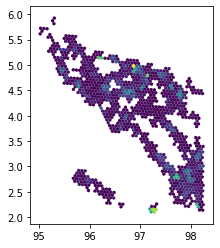

In [6]:
gdf_d = get_h3_gdf_area_ratio(
    raster_path="../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif",
    resolution=6, 
    area_raster_km2='../../datasets/processed/Satelligence_data/area_ratio/8_Areakm.tif',
    stat='max', all_touched=True
)
gdf_d.head()

In [174]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf_d[gdf_d['h3index'].isin(loc_indexes)]['val_dens'].sum()
    location_sum.append(sum_)

## Carbon - ddbb calculation:



,h3index,value,geometry,hex_area_km2,pix_area_km2,ratio,val_dens
0,866550587ffffff,1687,"POLYGON ((96.19086 4.90173, 96.19362 4.93819, ...",43.101232,85.740196,0.502696,848.047723
1,86655058fffffff,1687,"POLYGON ((96.12725 4.90647, 96.13000 4.94292, ...",43.102107,85.740196,0.502706,848.064946
2,86655059fffffff,1687,"POLYGON ((96.16319 4.95879, 96.16595 4.99525, ...",43.112374,85.729401,0.502889,848.373780
3,866554507ffffff,1822,"POLYGON ((96.97689 3.90935, 96.97972 3.94568, ...",42.874967,85.856300,0.499381,909.871379
4,866554517ffffff,1822,"POLYGON ((97.01285 3.96145, 97.01569 3.99779, ...",42.886012,85.847702,0.499559,910.196929


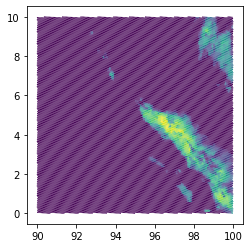

In [41]:
resolution = 6 
raster_path = '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_upmsampled_v2.tif'
area_raster_km2='../../datasets/processed/Satelligence_data/area_ratio/8_Areakm.tif'
stat='max'
all_touched=True
    
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf['h3index'] = [h3ind.split('x')[1] for h3ind in list(gdf['h3index'])]
    
#obtain area for each hexagon
    hex_area_list = []
    for i, row in gdf.iterrows():
        hex_area = h3.cell_area(row['h3index'])
        hex_area_list.append(hex_area)

    gdf['hex_area_km2'] = hex_area_list

    
    # zonal statistics to get the pixel area
    stats = zonal_stats(gdf,
                        area_raster_km2,
                        stats=stat,
                        all_touched = all_touched
                )
    
    gdf['pix_area_km2'] = [el['max'] for el in stats]
    ratio_list = []
    value_density_list = []
    for i, row in gdf.iterrows():
        ratio = row['hex_area_km2']/row['pix_area_km2']
        ratio_list.append(ratio)
        value_density = row['value']*ratio
        value_density_list.append(value_density)
    gdf['ratio'] = ratio_list
    gdf['val_dens'] = value_density_list
    
gdf.head()
#location_sum = []
#for index in gd_mills['index'].unique():
#    #filter dataframe and get h3 indexes
#    gdf_f = gd_mills[gd_mills['index']==index]
#    loc_indexes = list(gdf_f['h3_polyfil'])
#    sum_ = gdf[gdf['h3index'].isin(loc_indexes)]['value'].sum()
#    location_sum.append(sum_)

In [42]:
gdf_merge = gdf_d.merge(
    gdf,
    on='h3index',
    how='inner')
gdf_merge.head()

,h3index,value_x,geometry_x,hex_area_km2_x,pix_area_km2_x,ratio_x,val_dens_x,value_y,geometry_y,hex_area_km2_y,pix_area_km2_y,ratio_y,val_dens_y
0,866576737ffffff,0.993642,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ...",42.373203,85.986000,0.492792,0.489659,1084,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ...",42.373203,85.986000,0.492792,534.186402
1,866556397ffffff,2.927215,"POLYGON ((96.67214 4.92068, 96.67495 4.95714, ...",43.100277,85.740196,0.502685,1.471466,1656,"POLYGON ((96.67214 4.92068, 96.67495 4.95714, ...",43.100277,85.740196,0.502685,832.445713
2,86655676fffffff,2.927215,"POLYGON ((96.64455 4.97776, 96.64736 5.01422, ...",43.111897,85.729401,0.502883,1.472048,1656,"POLYGON ((96.64455 4.97776, 96.64736 5.01422, ...",43.111897,85.729401,0.502883,832.774994
3,8665766cfffffff,16.171299,"POLYGON ((97.88507 2.52876, 97.88800 2.56488, ...",42.470845,85.969902,0.494020,7.988944,973,"POLYGON ((97.88507 2.52876, 97.88800 2.56488, ...",42.470845,85.969902,0.494020,480.681390
4,866572707ffffff,0.617669,"POLYGON ((97.36014 3.11419, 97.36302 3.15040, ...",42.661624,85.926003,0.496493,0.306668,228,"POLYGON ((97.36014 3.11419, 97.36302 3.15040, ...",42.661624,85.926003,0.496493,113.200313


In [53]:
carbon_loss_density = []
carbon_loss_ = []
for i, row in gdf_merge.iterrows():
    def_area_dens =  row['val_dens_x']
    def_area =  row['value_x']
    biomass_dens = row['val_dens_y']
    biomass = row['value_y']
    ratio = row['ratio_y']
    carbon_loss_dens = def_area_dens*biomass_dens*ratio
    carbon_loss = def_area*biomass*ratio
    carbon_loss_density.append(carbon_loss_dens)
    carbon_loss_.append(carbon_loss)
gdf_merge['carb_loss_dens'] = carbon_loss_density
gdf_merge['carb_loss_'] = carbon_loss_
gdf_merge.head()

,h3index,value_x,geometry_x,hex_area_km2_x,pix_area_km2_x,ratio_x,val_dens_x,value_y,geometry_y,hex_area_km2_y,pix_area_km2_y,ratio_y,val_dens_y,carb_loss_dens,carb_loss_
0,866576737ffffff,0.993642,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ...",42.373203,85.986000,0.492792,0.489659,1084,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ...",42.373203,85.986000,0.492792,534.186402,128.899082,530.789999
1,866556397ffffff,2.927215,"POLYGON ((96.67214 4.92068, 96.67495 4.95714, ...",43.100277,85.740196,0.502685,1.471466,1656,"POLYGON ((96.67214 4.92068, 96.67495 4.95714, ...",43.100277,85.740196,0.502685,832.445713,615.746242,2436.747859
2,86655676fffffff,2.927215,"POLYGON ((96.64455 4.97776, 96.64736 5.01422, ...",43.111897,85.729401,0.502883,1.472048,1656,"POLYGON ((96.64455 4.97776, 96.64736 5.01422, ...",43.111897,85.729401,0.502883,832.774994,616.477223,2437.711736
3,8665766cfffffff,16.171299,"POLYGON ((97.88507 2.52876, 97.88800 2.56488, ...",42.470845,85.969902,0.494020,7.988944,973,"POLYGON ((97.88507 2.52876, 97.88800 2.56488, ...",42.470845,85.969902,0.494020,480.681390,1897.104049,7773.242471
4,866572707ffffff,0.617669,"POLYGON ((97.36014 3.11419, 97.36302 3.15040, ...",42.661624,85.926003,0.496493,0.306668,228,"POLYGON ((97.36014 3.11419, 97.36302 3.15040, ...",42.661624,85.926003,0.496493,113.200313,17.235711,69.920356


In [54]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf_merge[gdf_merge['h3index'].isin(loc_indexes)]['carb_loss_dens'].sum()
    location_sum.append(sum_)

,h3index,value,geometry,hex_area_km2,pix_area_km2,ratio,val_dens
0,866553457ffffff,271.796875,"POLYGON ((95.06519 5.70016, 95.06783 5.73670, ...",43.221506,85.623299,0.504787,137.199460
1,866509637ffffff,194.131668,"POLYGON ((97.61824 4.35435, 97.62115 4.39073, ...",42.947874,85.801598,0.500549,97.172346
2,86650978fffffff,194.131668,"POLYGON ((97.65434 4.40649, 97.65725 4.44287, ...",42.957131,85.801598,0.500657,97.193289
3,8665097afffffff,194.131668,"POLYGON ((97.68169 4.34950, 97.68460 4.38587, ...",42.943208,85.801598,0.500494,97.161787
4,866552347ffffff,78.551422,"POLYGON ((95.59505 5.49620, 95.59775 5.53272, ...",43.204484,85.660301,0.504370,39.618979


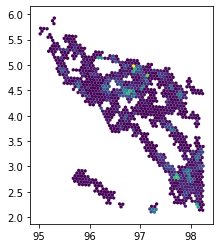

In [50]:
#precalculated
gdf_c = get_h3_gdf_area_ratio(
    raster_path='../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_sum_upsample.tif',
    resolution=6, 
    area_raster_km2='../../datasets/processed/Satelligence_data/area_ratio/8_Areakm.tif',
    stat='max', all_touched=True
)
gdf_c.head()

In [51]:
location_sum = []
for index in gd_mills['index'].unique():
    #filter dataframe and get h3 indexes
    gdf_f = gd_mills[gd_mills['index']==index]
    loc_indexes = list(gdf_f['h3_polyfil'])
    sum_ = gdf_c[gdf_c['h3index'].isin(loc_indexes)]['val_dens'].sum()
    location_sum.append(sum_)